In [ ]:
# !pip install numpy 

In [1]:
import numpy as np
import copy
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#dataset load function
def load_dataset():
    train_dataset = h5py.File('catdataset/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('catdataset/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


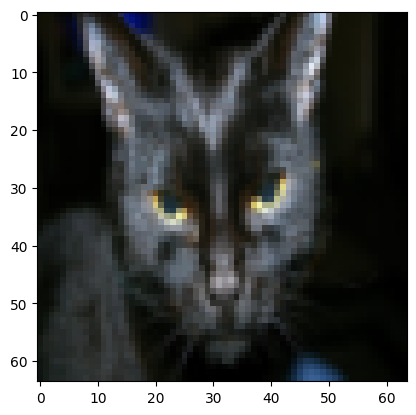

In [4]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [5]:
#Remember that train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b ∗ c ∗d, a) is to use:

X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X

In [6]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T 

In [7]:
# Check that the first 10 pixels of the second image are in the correct place
assert np.alltrue(train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]), "Wrong solution. Use (X.shape[0], -1).T."
assert np.alltrue(test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]), "Wrong solution. Use (X.shape[0], -1).T."

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


Common steps for pre-processing a new dataset are:

Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1)
"Standardize" the data

In [8]:
#To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

The main steps for building a Neural Network are:

Define the model structure (such as number of input features)
Initialize the model's parameters
Loop:
Calculate current loss (forward propagation)
Calculate current gradient (backward propagation)
Update parameters (gradient descent)

In [9]:
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


In [10]:
x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)

[0.62245933 0.5        0.88079708]


In [11]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """

    w = np.zeros((dim, 1))
    b = 0.0
    return w, b
    
dim = 2
w, b = initialize_with_zeros(dim)
assert type(b) == float #verifies that b is of type float
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


In [12]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression

    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
   

    # compute activation using the sigmoid formula: 1 / (1 + exp(-z))
    A = 1 / (1 + np.exp(-(np.dot(w.T, X) + b)))
    
    # compute cost using np.dot to perform the summation of the log-likelihood
    cost = (-1 / m) * (np.dot(Y, np.log(A).T) + np.dot((1 - Y), np.log(1 - A).T))

    

    # BACKWARD PROPAGATION (TO FIND GRAD)
   

    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    

    
    cost = np.squeeze(np.array(cost))


    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [13]:
w =  np.array([[1.], [2]])
b = 1.5

# X is using 3 examples, with 2 features each
# Each example is stacked column-wise
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.1250040450043965
cost = 0.15900537707692405


Write down the optimization function. The goal is to learn  𝑤 and  𝑏 by minimizing the cost function  𝐽
 . For a parameter  𝜃
 , the update rule is  𝜃=𝜃−𝛼 𝑑𝜃
 , where  𝛼 is the learning rate.

In [14]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """

    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(num_iterations):
       
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the costs
        if i % 100 == 0 : 
            costs.append(cost)

            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
                

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [15]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = [array(0.15900538)]


Time to Predict

In [16]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)


    for i in range(A.shape[1]):

        if A[0, i] > 0.5 :
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0

    return Y_prediction

In [17]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))


predictions = [[1. 1. 0.]]


Lets Merge All  a make a model

In [24]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

 

    # initialize parameters with zeros
    # and use the "shape" function to get the first dimension of X_train (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "params"
    w = params["w"]
    b = params["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [25]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 1, you predicted that it is a "cat" picture.


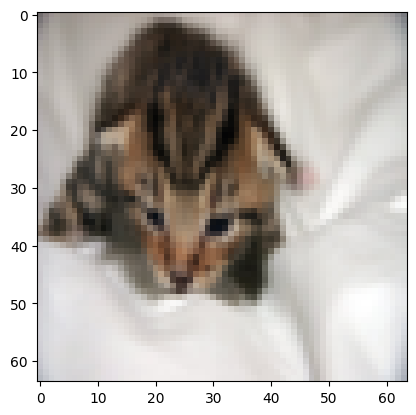

In [26]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

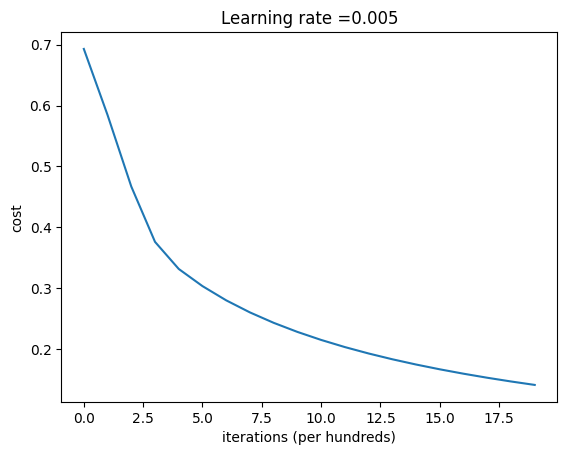

In [28]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

In [ ]:
Further Analysis:  Choice of Learning Rate

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



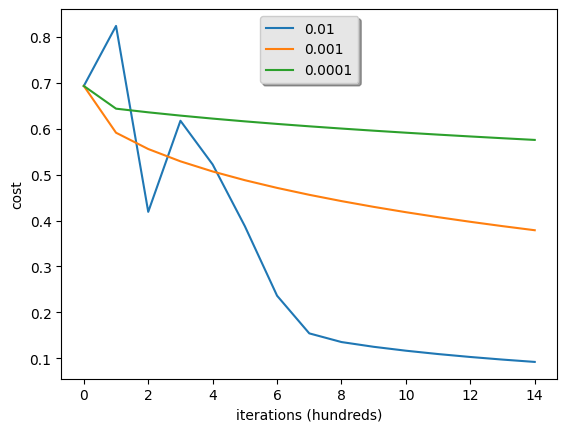

In [27]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

(64, 64, 3)
y = 0.0, your algorithm predicts a "non-cat" picture.


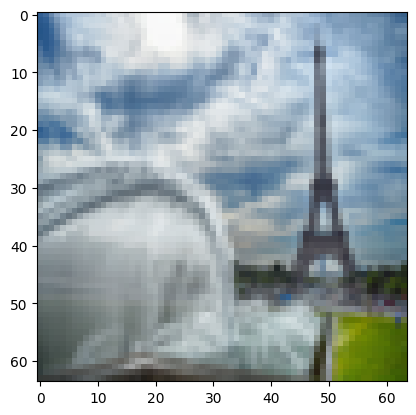

In [35]:
# Test with your own image
# change this to the name of your image file
my_image = "my_image.jpg"

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
print(image.shape)
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")